# Feature Scaling and Model Evaluation

## Objectives

* Learn and implement different approaches to feature scaling, and when to use it
* Building some grasp of when to use what machine learning algorithm
* Apply model evaluation skills to a difficut data set

## Data Objectives

We'll be working with a dataset that can be difficult to accurately predict! We'll learn why it's important to go beyond just using accuracy when working in classification problems, hypothesize some approaches to working with the features we have, and have a discussion on what are we gaining versus losing.

## Class Notes

### The Data

Included in the repository today is a used car sale data set. Many features relate to cost, though they are all defined in the data dictionary here:

In [1]:
lines = open('../data/lemons_description.txt')
for line in lines:
    print line.strip()

Field Name                          Definition
RefID                               Unique (sequential) number assigned to vehicles
IsBadBuy                            Identifies if the kicked vehicle was an avoidable purchase
PurchDate                           The Date the vehicle was Purchased at Auction
Auction                             Auction provider at which the  vehicle was purchased
VehYear                             The manufacturer's year of the vehicle
VehicleAge                          The Years elapsed since the manufacturer's year
Make                                Vehicle Manufacturer
Model                               Vehicle Model
Trim                                Vehicle Trim Level
Submodel                            Vehicle Submodel
Color                               Vehicle Color
Transmission                        Vehicles transmission type (Automatic, Manual)
WheelTypeID                         The type id of the vehicle wheel
WheelType                  

In [2]:
import pandas as pd
from sklearn import tree
from sklearn.cross_validation import cross_val_score

# Load in data and create sets. dropping all na columns on the live data set.
lemons = pd.read_csv('../data/lemons.csv')
lemons_oos = pd.read_csv('../data/lemons_oos.csv')
print lemons.dtypes

RefId                                  int64
IsBadBuy                               int64
PurchDate                             object
Auction                               object
VehYear                                int64
VehicleAge                             int64
Make                                  object
Model                                 object
Trim                                  object
SubModel                              object
Color                                 object
Transmission                          object
WheelTypeID                          float64
WheelType                             object
VehOdo                                 int64
Nationality                           object
Size                                  object
TopThreeAmericanName                  object
MMRAcquisitionAuctionAveragePrice    float64
MMRAcquisitionAuctionCleanPrice      float64
MMRAcquisitionRetailAveragePrice     float64
MMRAcquisitonRetailCleanPrice        float64
MMRCurrent

Below includes a very simple "benchmark" script. One common test we'd want to consider for model evaluation is if we can do better than random, which we can use the sklearn DummyClassifier to do.

In [6]:
lemons = lemons.dropna(axis=1)
# Generating a list of continuous data features from the describe dataframe. 
# Then, removing the two non-features (RefId is an index, IsBadBuy is the prediction value)
features = list(lemons.describe().columns)
features.remove('RefId')
features.remove('IsBadBuy')

best_score = -1
for depth in range(1, 10):
    scores = cross_val_score(tree.DecisionTreeClassifier(max_depth=depth, random_state=1234),
                                lemons[features],
                                lemons.IsBadBuy,
                                scoring='roc_auc',
                                cv=5)
    if scores.mean() > best_score:
        best_depth = depth
        best_score = scores.mean()

# Is the best score we have better than each DummyClassifier type?
from sklearn import dummy, metrics
for strat in ['stratified', 'most_frequent', 'uniform']:
    dummyclf = dummy.DummyClassifier(strategy=strat).fit(lemons[features], lemons.IsBadBuy)
    print 'did better than %s?' % strat, metrics.roc_auc_score(lemons.IsBadBuy, dummyclf.predict(lemons[features])) < best_score

# seems so!

# Create a classifier and prediction.
clf = tree.DecisionTreeClassifier(max_depth=depth, random_state=1234).fit(lemons[features], lemons.IsBadBuy)
#
y_pred = clf.predict(lemons_oos[features])
#
## Create a submission
submission = pd.DataFrame({ 'RefId' : lemons_oos.RefId, 'prediction' : y_pred })
submission.head()
submission.to_csv('submission.csv')

did better than stratified? True
did better than most_frequent? True
did better than uniform? True


In [10]:
csv = pd.read_csv('submission.csv')
print csv.head()

   Unnamed: 0  RefId  prediction
0           0      3           0
1           1      4           0
2           2      8           0
3           3      9           0
4           4     10           0


This is a good start for us!

In order for us to work on improving this model, we'll have to continue exploring the data set available, impute missing values, create new features, and scale numerical values. 

### Feature Scaling

Feature scaling can play a significant role in the performance of our model. Many of the techniques that follow are typically more applicable to algorithms were the algorithm is less dependent on learning weights; in particular, for classifiers. 

### Zeroing on the mean / Centering a feature

One common technique is to subtract the mean away from all values in a feature. This effectively "zeroes" the feature, and is easier for the model to assert the normal centers of the data as being the same.

$x^` = x - mean(x)$


### Normalizing the feature

Another common technique takes the above one step further: not only do we center the data on 0, but then provide a scope for the data to reside in (either -1 to 1, or 0 to 1, are typical). Normalizing the fe

**Normalizing to 0 and 1 (where 0 remains 0)**

$x^` = \dfrac{x_0}{max(x)}$


**Normalizing to 0 and 1 (where min == 0)**

$x^` = \dfrac{x_0 - min(x)}{max(x) - min(x))}$

**Normalizing to -1 and 1 (where mean == 0)**

$x^` = \dfrac{x_0 - mean(x)}{max(x) - mean(x)}$

**Standardization using mean and standard deviation (where mean = 0)**

Standardization is a slightly different process for normalizing where our data splits are represented using standard deviations instead.

$x^` = \dfrac{x_0 - mean(x)}{std(x))}$

### Practice: Writing python functions to handle these transformations

Assuming the input of an array, how would we end up writing code to handle each of these transformations?

In [16]:
import numpy as np
from __future__ import division
class Transformations(object):

    def mean_at_zero(self, arr):
        return np.array([i - np.mean(arr) for i in arr])

    def norm_to_min_zero(self, arr):
        return np.array([i / max(arr) for i in arr])
    
    def norm_to_absolute_min_zero(self, arr):
        """should be a range of 0 to 1, where 0 maintains its 0 value"""
    
    def norm_to_neg_pos(self, arr):
        """should be a range of -1 to 1, where 0 represents the mean"""
    
    def norm_by_std(self, arr):
        """should be a range where 0 represents the mean"""

## tests to make sure we built this correctly:
transformer = Transformations()
a = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
print transformer.mean_at_zero(a) == np.array([-2, -1, 0, 1, 2])
print transformer.norm_to_min_zero(a) == np.array([0.2, 0.4, 0.6, 0.8, 1.0])
#print transformer.norm_to_absolute_min_zero(a) == np.array([0.0, 0.25, 0.5, 0.75, 1.0])
#print transformer.norm_to_neg_pos(a) == np.array([-1.0, -0.5, 0.0, 0.5, 1.0])
#print transformer.norm_by_std(a) == np.array([-1.414213562373095, -0.7071067811865475, 0.0, 0.7071067811865475, 1.414213562373095])


[ True  True  True  True  True]
[ True  True  True  True  True]


Scikit learn has functions to also handle some of this:

In [17]:
from sklearn import preprocessing
print a
print preprocessing.scale(a, with_mean=True, with_std=False)
print preprocessing.scale(a, with_mean=True, with_std=True)

[ 1.  2.  3.  4.  5.]
[-2. -1.  0.  1.  2.]
[-1.41421356 -0.70710678  0.          0.70710678  1.41421356]


### Solving Power Laws

In class, we previously learned about linear transformations, particularly using log when we're looking at a log-log distribution.

<img src='img/powerlaw.jpg'>

However, transforming to log isn't always going to land us a perfect linear fit. Instead, we'd ideally like to solve for the power law, which is identifying a curve's amplitude and index. We can do this with one extra step: fitting a linear model to the log(10)-transformed data, optimizing against the error. scipy has a handy function to solve this for us.

Another option could be to experiment with the [plfit](https://github.com/keflavich/plfit) library (not included in anaconda).

In [18]:
%matplotlib inline
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

class PowerLaw(object):
    def fit(self, x, y, transform=True):
        """
        returns back the amplitude and index of a powerlaw relationship.
        assumes the data is not already log10 transformed.
        return: [index, amp], also stored on the instance
        """
        if transform:
            x = np.log10(x)
            y = np.log10(y)
        # define our (line) fitting function and error function to optimize on
        fitfunc = lambda p, x: p[0] + p[1] * x
        errfunc = lambda p, x, y: (y - fitfunc(p, x))
        # defines a starting point to optimize from.
        p_init = [1.0, -1.0] 
        out = sp.optimize.leastsq(errfunc, p_init, args=(x, y), full_output=1)
        result = out[0]
        self.index = result[1]
        self.amp = 10.0**result[0]
        return np.array([self.amp, self.index])
    
    def transform(self, x):
        """returns the x-transformed data"""
        return self.amp * (x**self.index)

amp: 0.895599738306 index -0.409432655356


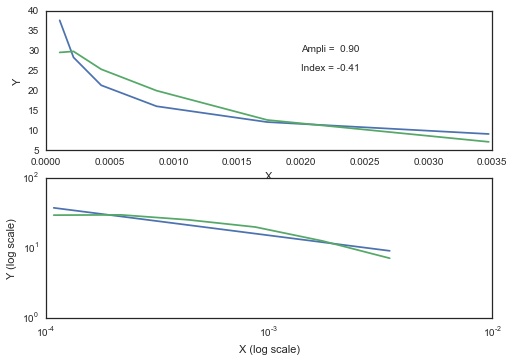

In [19]:
xdata=np.array([ 0.00010851,  0.00021701,  0.00043403,  0.00086806,  0.00173611, 0.00347222])
ydata=np.array([ 29.56241016,  29.82245508,  25.33930469,  19.97075977,  12.61276074, 7.12695312])

powerlaw = PowerLaw()
powerlaw.fit(xdata, ydata)
print 'amp:',powerlaw.amp, 'index', powerlaw.index

sns.set_style('white')
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(xdata, powerlaw.transform(xdata))
plt.plot(xdata, ydata)
plt.text(0.0020, 30, 'Ampli = %5.2f' % powerlaw.amp)
plt.text(0.0020, 25, 'Index = %5.2f' % powerlaw.index)
plt.xlabel('X')
plt.ylabel('Y')
plt.subplot(2, 1, 2)
plt.loglog(xdata, powerlaw.transform(xdata))
plt.plot(xdata, ydata)
plt.xlabel('X (log scale)')
plt.ylabel('Y (log scale)')

### Reviewing Model performance

We have introduce several different concepts in class to understanding model performance throughout the last few weeks; here is one primary location that we can refer to for regressions and classification problems.

### Regressions

**R-Squared**

Definition: On (technically) a scale of 0 to 1, how well does this regression explain the variance in our data?  
_note: can be negative if the regression model is inversely related, though this rarely occurs_

math: $R^2=\dfrac{SS_{res}}{SS_{tot}}$

* we like this because: It's easily explainable on a scale, independent of what your y represents. very universal
* we don't like this because: it doesn't actually represent any "error" amount

**Root Mean Squared Error (RMSE)**

Definition: The square root of the mean of the squared errors, where squared error = $(y_{true} - y_{pred})^{2}$

math: $\sqrt{\dfrac{1}{n}\sum(y_{true} - y_{pred})^{2}}$

* we like this because: It represents error against the y units, unlike $R^2$, and punishes larger error
* we don't like this because: if the scale of y changes dependent on the model, it's tough to compare results

### Classification

**Confusion Matrix**

Definition: Given class labels, a true vs predicted label for all observations.


<img src='img/confusion_matrix_metrics.png'/>

* we like this because: It's the core object for solving for a variety of classification metrics
* we don't like this because: we actually just like this
* **business prop**: in a business decision, what's the value to error? How much is a true positive worth to a business vs a false positive or false negative? Consider weighting against some business goal.

**Accuracy**

Definition and math: $\dfrac{TP + TN}{TP + TN + FP + FN}$

* we like this because: It is a nice "overall" number to look at.

**Misclassification Rate**

Definition and math: $\dfrac{FP + FN}{TP + TN + FP + FN}$

* we like this because: it provides the 1 - accuracy value, a number we want to drive down


**false positive rate (fpr)**

Definition: The percent of the negatives were predicted as positive (how often is the predictor wrong on negatives?)

Math: $\dfrac{FP}{FP + FN}$

**true positive rate/recall (tpr)**

Definition: The percent of the positives were accurately measured as positives

Math: $\dfrac{TP}{TP + FN}$

** ROC Curve and AUC**

Definition: The area of a [1, 1] plot given the a line drawn from [0,0], [fpr, tpr], and [1, 1]

Note there are two routes to go with using AUC in python:

* **plotting classes**: calculate the roc using the binary class labels to gain a single point on the plot and visualize
* **plotting scores/probalities**: calcuate the roc using the probalities for class $y_1$. Helpful to visualize when the data may not be weighted normally (a priori is not around .5)

All of sklearn's model metrics are in the [sklearn metrics page](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics). Keep this around as a reference point so you know how to run the metrics you need to use!

## Guided Practice

Back to the data problem at hand!

We'll start by working through an explain on each column in the dataset together as a class and come up with some ideas on how to handle each column.

In [20]:
print lemons.groupby('Auction').Auction.count()
print lemons.groupby('Auction').IsBadBuy.mean()

# seems like the ADESA auction is particularly worse for bad buys (about 36% more)
# it may help to create a new column that specically refers to "is_adesa"

lemons['auct_adesa'] = lemons.Auction.apply(lambda x: 1 if x == 'ADESA' else 0)

print lemons.groupby('auct_adesa').IsBadBuy.mean()

Auction
ADESA      10128
MANHEIM    28645
OTHER      12315
Name: Auction, dtype: int64
Auction
ADESA      0.153732
MANHEIM    0.114400
OTHER      0.118149
Name: IsBadBuy, dtype: float64
auct_adesa
0             0.115527
1             0.153732
Name: IsBadBuy, dtype: float64


(array([  1.00000000e+00,   2.15900000e+03,   5.93600000e+03,
         1.11580000e+04,   1.19690000e+04,   9.06400000e+03,
         5.57700000e+03,   3.23400000e+03,   1.53200000e+03,
         4.58000000e+02]), array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]), <a list of 10 Patch objects>)
VehicleAge
0             0.000000
1             0.044465
2             0.062163
3             0.083259
4             0.110118
5             0.146293
6             0.180384
7             0.219852
8             0.253916
9             0.316594
Name: IsBadBuy, dtype: float64


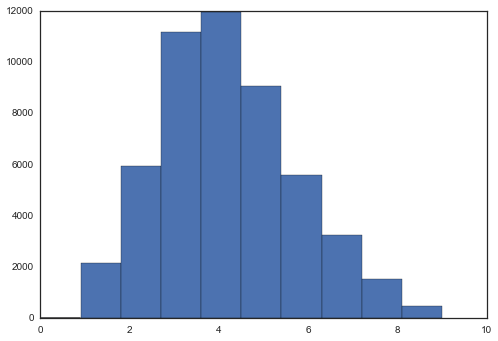

In [21]:
print plt.hist(lemons.VehicleAge)

print lemons.groupby('VehicleAge').IsBadBuy.mean()

# there seems to be a stronger relationship with bad buys as vehicles are older.
# is there anything we should do here?

### Group Work

1. Continue to parse through each column and determine relationships against IsBadBuy.
    1. Is there missing data? How should it be imputed? What does the missing data mean?
    2. Are there any clear relationships?
    3. Do we need to be concerned with feature scaling?

2. Generate a model in your group. The goal should be a cross validated model that, on average, performs better than the benchmark on the training data.
3. Once you've created a model your team is comfortable with, generate a "submission" csv file on the out of sample data. Ed, Julia, and Pooja will post "scores" against the actual values for the out of sample data.

Once you've done so, use the rest of the class today to work on your projects individually. Use this time to practice everything we learned today and to improve your project 2 for Monday.